In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/zzc3/source_code/

/content/drive/MyDrive/zzc3/source_code


dataset.py

In [3]:
import cv2
import numpy as np
import torch
import glob
from torch.utils.data import Dataset

def iou(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

class BrainDataset(Dataset):
    def __init__(self, anchors, mode = "train", S=[13, 26, 52], image_size = 416, num_classes = 1, transform = None, root="/content/drive/MyDrive/zzc3/"):
        self.iou_threshold = 0.5
        self.image_names = []
        self.label_names = []
        self.S = S
        self.num_classes = num_classes
        self.transform = transform
        self.anchors = torch.tensor(anchors[0]+anchors[1]+anchors[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = int(self.num_anchors/3)
        tmp_image_names = sorted(glob.glob(root+"dataset/images/"+mode+"/*"))
        tmp_labels_names = glob.glob(root+"dataset/labels/"+mode+"/*")
        for image_name in tmp_image_names:
            i_name = image_name.split("/")[-1][:-4]
            check_label_file = root+"dataset/labels/"+mode+"/"+i_name+".txt"
            if check_label_file in tmp_labels_names:
                self.image_names.append(image_name)
                self.label_names.append(check_label_file)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_path = self.image_names[index]
        label_path = self.label_names[index]
        image = cv2.imread(image_path)
        label_data = np.roll(np.loadtxt(label_path, delimiter = " ", ndmin=2), 4, axis=1).tolist() # X,Y,W,H,CLASS
        if self.transform:
            augmentations = self.transform(image=image, bboxes=label_data)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        targets = [torch.zeros((self.num_anchors//3, S, S, 6)) for S in self.S]

        for box_elem in bboxes:
            iou_anchors = iou(torch.tensor(box_elem[2:4]), self.anchors) # send width and height to calc anchor's iou
            anchor_indices = iou_anchors.argsort(descending=True, dim = 0)
            x,y,w,h,class_label = box_elem
            has_anchor = [False]*3

            for anchor_idx in anchor_indices:
                branch_index = anchor_idx // self.num_anchors_per_scale # 0,1,2
                anchor_on_branch = anchor_idx % self.num_anchors_per_scale
                S = self.S[branch_index]
                j, i = int(S*y), int(S*x)
                anchor_taken = targets[branch_index][anchor_on_branch, j, i, 0]

                if not anchor_taken and not has_anchor[branch_index]:
                    targets[branch_index][anchor_on_branch, j, i, 0] = 1
                    x_cell, y_cell = S*x - i, S*y - j
                    w_cell, h_cell = S*w, S*h
                    box_coord = torch.tensor(
                        [x_cell, y_cell, w_cell, h_cell]
                    )
                    targets[branch_index][anchor_on_branch, j, i, 1:5] = box_coord
                    targets[branch_index][anchor_on_branch, j, i, 5] = int(class_label)
                    has_anchor[branch_index] = True
                elif not anchor_taken and iou_anchors[anchor_idx] > self.iou_threshold:
                    targets[branch_index][anchor_on_branch, j, i, 0] = -1
        return image, tuple(targets), image_path, label_path

model.py

In [4]:
import torch
import torch.nn as nn
import json

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class BranchPrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.num_anchors = 3
        self.num_classes = num_classes
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * self.num_anchors, bn_act=False, kernel_size=1
            ),
        )

    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], self.num_anchors, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        self.use_residual = use_residual
        self.num_repeats = num_repeats
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]


    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class YOLOv8(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.config_list = json.load(open("yolo_configuration.json","r"))
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, BranchPrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in self.config_list["layers"]:
            if len(module)==3:
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif len(module)==2:
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif len(module)==1:
                if module[0] == "BRANCH":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        BranchPrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module[0] == "UPSAMPLE":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers

if __name__ == "__main__":
    num_classes = 20
    IMAGE_SIZE = 416
    model = YOLOv8(num_classes=num_classes)
    x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
    out = model(x)
    print(out[0].shape)
    assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
    assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
    assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
    print("Success!")

torch.Size([2, 3, 13, 13, 25])
Success!


util.py

In [5]:
import torch


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Video explanation of this function:
    https://youtu.be/YDkjWEN8jNA

    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

loss_fn.py

In [8]:
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss() # for bbox
        self.bce = nn.BCEWithLogitsLoss()
        self.cls_loss = nn.BCEWithLogitsLoss()
        self.sigmoid = nn.Sigmoid()
        self.const_cls = 1
        self.const_noobj = 10
        self.const_obj = 1
        self.const_bbox = 10

    def forward(self, predictions, target, anchors):
        obj = target[...,0] == 1
        noobj = target[...,0] == 0

        # No-obj loss
        no_obj_loss = self.bce((predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]))

        # Obj loss
        anchors = anchors.reshape(1,3,1,1,2)
        box_preds = torch.cat([self.sigmoid(predictions[...,1:3]), torch.exp(predictions[...,3:5]*anchors)], dim = -1)
        ious = intersection_over_union(box_preds[obj], target[...,1:5][obj]).detach()
        object_loss = self.bce((predictions[...,0:1][obj]), (ious*target[...,0:1][obj]))

        # Box Coord Loss
        predictions[...,1:3] = self.sigmoid(predictions[...,1:3])
        target[...,3:5] = torch.log(1e-8+target[...,3:5]/anchors)
        box_loss = self.mse(predictions[...,1:5][obj], target[...,1:5][obj])

        # Class Loss
        class_loss = self.bce((predictions[...,5:6][obj]),(target[...,5:6][obj]))

        total_loss = (self.const_bbox * box_loss)+(self.const_obj*object_loss)+(self.const_noobj*no_obj_loss)+(self.const_cls*class_loss)
        return total_loss

run.py

In [6]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np
import cv2
import glob
import os
import argparse
import matplotlib.pyplot as plt

Training the Yolo model

In [11]:
# Define constants and hyperparameters
LR = 4e-3
DIM = 416
EPOCH = 2  # Set epoch to 1
MODE = "train"  # Set mode to train
ROOT = "/content/drive/MyDrive/zzc3/"
RELOAD = 0
yolo_v8_model = YOLOv8()
loss_fn =YoloLoss()

optimizer = optim.Adam(yolo_v8_model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=3, gamma=0.05)

ANCHORS= [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]
NMS_IOU_THRESH = 0.05
CONF_THRESHOLD = 0.40
S = [13, 26, 52]

scaled_anchors = torch.tensor(ANCHORS)*(torch.tensor([13, 26, 52]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))



Train Epoch 1:   0%|          | 0/146 [00:00<?, ? Train batch/s]/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Train Epoch 1: 100%|██████████| 146/146 [33:09<00:00, 13.63s/ Train batch]


Epoch 1
train_loss : 42.628829606591836
Saving Weights started


Train Epoch 2: 100%|██████████| 146/146 [30:39<00:00, 12.60s/ Train batch]


Epoch 2
train_loss : 7.027427016872249
Saving Weights started


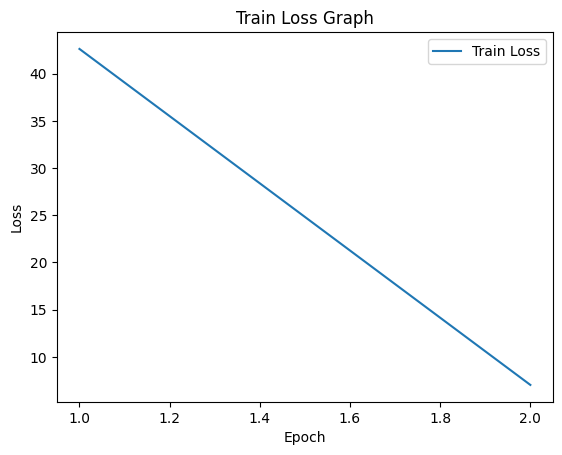

In [12]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()



def plot(image, bbox, color, type="mid"):
    try:
        image_shape = image.shape
        if color == "green":
            color = [0,255,0]
        elif color == "red":
            color = [0,0,255]
        elif color == "blue":
            color = [255,0,0]
        if type == "mid":
            cx,cy = int(bbox[2]*image_shape[1]), int(bbox[3]*image_shape[0])
            w,h = int(bbox[4]*image_shape[1]), int(bbox[5]*image_shape[0])
            x1,y1 = cx-int(w/2), cy-int(h/2)
            x2,y2 = cx+int(w/2), cy+int(h/2)
        else:
            x1,y1 = int(bbox[2]*image_shape[1]), int(bbox[3]*image_shape[0])
            x2,y2 = int(bbox[4]*image_shape[1]), int(bbox[4]*image_shape[0])
        start_point = (x1,y1)
        end_point = (x2,y2)
        image = cv2.rectangle(image, start_point, end_point, color, thickness=1)
    except:
        pass
    return image


def save_image(gt_image, pred_image, image_path):
    write_path = ROOT+"image_plots/"+image_path.split("/")[-1]
    gt_image = cv2.putText(gt_image, 'Ground Truth', (30,30), cv2.FONT_HERSHEY_SIMPLEX ,  1, (255,255,255), 2, cv2.LINE_AA)
    pred_image = cv2.putText(pred_image, 'Prediction', (30,30), cv2.FONT_HERSHEY_SIMPLEX ,  1, (255,255,255), 2, cv2.LINE_AA)
    image = cv2.hconcat([gt_image, pred_image])
    cv2.imwrite(write_path,image)


def train_yolo_v8():
    transform_train = A.Compose(
                [   A.Resize(height=DIM, width=DIM),
                    A.CLAHE(p=1.0),
                    A.HorizontalFlip(p=0.5),
                    A.Rotate(limit=30, p=0.25),
                    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
                    ToTensorV2(),
                ], bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
                )
    clip_value = 3
    min_train_loss = 1000000
    epoch_tr_loss = []
    if RELOAD != 0:
        weight_path = glob.glob(ROOT+"weights/"+str(RELOAD)+".pth")
        yolo_v8_model.load_state_dict(torch.load(weight_path[0]))
    yolo_v8_model.train() # switch to train mode
    training_data = BrainDataset(ANCHORS, transform=transform_train, mode="train",root=ROOT)
    train_dataloader = DataLoader(training_data, batch_size=3, shuffle=True, pin_memory=True)
    if not os.path.exists(ROOT+"weights/"):
        os.system("mkdir "+ROOT+"weights/")
    for ep in range(RELOAD,EPOCH):
        train_losses = []
        with tqdm(train_dataloader, unit=" Train batch") as tepoch:
            tepoch.set_description(f"Train Epoch {ep+1}")
            for input_images, labels, image_paths, label_paths in tepoch:
                y0, y1, y2 = (
                                labels[0],
                                labels[1],
                                labels[2],
                            )
                with torch.cuda.amp.autocast():
                    out = yolo_v8_model(input_images)

                    loss = loss_fn(out[0], y0, scaled_anchors[0]) + loss_fn(out[1], y1, scaled_anchors[1]) + loss_fn(out[2], y2, scaled_anchors[2])
                    train_losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(yolo_v8_model.parameters(), clip_value)
                optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        epoch_tr_loss.append(epoch_train_loss)
        print(f'Epoch {ep+1}')
        print(f'train_loss : {epoch_train_loss}')
        if epoch_train_loss < min_train_loss:
            # Zhichen: check if it's working
            print("Saving Weights started")
            os.system("rm "+ROOT+"weights/*.pth")
            torch.save(yolo_v8_model.state_dict(), ROOT+"weights/"+str(ep+1)+".pth")
            min_train_loss = epoch_train_loss
    # Zhichen: plot train loss graph
    epoch = list(range(1, EPOCH+1))
    plt.plot(epoch, epoch_tr_loss, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss Graph')
    plt.legend()
    plt.show()

def test_yolo_v8():
    weights_path = glob.glob(ROOT+"weights/*.pth")
    if len(weights_path) == 0:
        print("No weights file present in weights/")
    else:
        weights_path = weights_path[0] # takes the file to load
        print("Loading Weights: ",weights_path)
    transform_test = A.Compose(
                [   A.Resize(height=DIM, width=DIM),
                    A.CLAHE(p=1.0),
                    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
                    ToTensorV2(),
                ], bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
                )
    yolo_v8_model.load_state_dict(torch.load(weights_path))
    yolo_v8_model.eval()
    test_data = BrainDataset(ANCHORS , transform=transform_test, mode="test", root=ROOT)
    test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, pin_memory=True)
    test_losses = []
    # below code works only for batch size = 1
    with tqdm(test_dataloader, unit=" Test batch") as tepoch:
        for input_images, labels, image_paths, label_paths in tepoch:
            batch_size = input_images.shape[0]
            y0, y1, y2 = (
                labels[0],
                labels[1],
                labels[2],
            )
            with torch.no_grad():
                out = yolo_v8_model(input_images)
                loss = loss_fn(out[0], y0, scaled_anchors[0]) + loss_fn(out[1], y1, scaled_anchors[1]) + loss_fn(out[2], y2, scaled_anchors[2])
                test_losses.append(loss.item())
                bboxes = [[] for _ in range(batch_size)]
                for i in range(3):
                            S = out[i].shape[2]
                            anchor = torch.tensor([*ANCHORS[i]]) * S
                            boxes_scale_i = cells_to_bboxes(
                                out[i], anchor, S=S, is_preds=True
                            )
                            for idx, (box) in enumerate(boxes_scale_i):
                                bboxes[idx] += box



                # we just want one bbox for each label, not one for each scale
                # true_bboxes = cells_to_bboxes(labels[2], ANCHORS, S=S, is_preds=False)
                all_pred_boxes = [] # specified as [class_prediction, prob_score, cx, cy, w, h]
                # all_true_boxes = [] # specified as [class_prediction, prob_score, cx, cy, w, h]
                for idx in range(batch_size):
                    nms_boxes = non_max_suppression(
                        bboxes[idx],
                        iou_threshold=NMS_IOU_THRESH,
                        threshold=CONF_THRESHOLD,
                        box_format="midpoint",
                    )

                    for nms_box in nms_boxes:
                        all_pred_boxes.append(nms_box)

                    # for box in true_bboxes[idx]:
                    #     if box[1] > CONF_THRESHOLD:
                    #         all_true_boxes.append(box)

                for image_idx in range(len(image_paths)):
                    image_path = image_paths[image_idx]
                    label_path = label_paths[image_idx]
                    image = cv2.imread(image_path) # its a square dimensional image 256x256
                    image = cv2.resize(image, (DIM, DIM))
                    gt_image = image.copy()
                    pred_image = image
                    label_data = np.loadtxt(label_path, delimiter = " ", ndmin=2).tolist()
                    for iddx in range(len(label_data)):
                        label_data[iddx].insert(1,1)
                    # for gt in all_true_boxes:
                    #     gt_image = plot(gt_image, gt, "green")
                    for gt in label_data:
                        gt_image = plot(gt_image, gt, "green")
                    for pred in all_pred_boxes:
                        pred_image = plot(image, pred, "red")
                    save_image(gt_image, pred_image, image_path)
        # Zhichen: plot train loss graph
        plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
        plt.xlabel('Image')
        plt.ylabel('Loss')
        plt.title('Test Loss Graph')
        plt.legend()
        plt.show()
        print(f'test_loss : {np.mean(test_losses)}')



if MODE == "train":
    train_yolo_v8()
elif MODE == "test":
    test_yolo_v8()
else:
    print("Set --mode to train or test. Example: python3 train.py --mode train")

Test the model

In [13]:
# Define constants and hyperparameters
LR = 4e-3
DIM = 416
EPOCH = 2  # Set epoch to 1
MODE = "test"  # Set mode to train
ROOT = "/content/drive/MyDrive/zzc3/"
RELOAD = 0
yolo_v8_model = YOLOv8()
loss_fn =YoloLoss()

optimizer = optim.Adam(yolo_v8_model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=3, gamma=0.05)

ANCHORS= [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]
NMS_IOU_THRESH = 0.05
CONF_THRESHOLD = 0.40
S = [13, 26, 52]

scaled_anchors = torch.tensor(ANCHORS)*(torch.tensor([13, 26, 52]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))

Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [03:13<00:00,  2.57s/ Test batch]


Epoch 1 - Accuracy: 25.51%
Epoch 1 - Test Loss: 11.177299143473308
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:38<00:00,  1.32s/ Test batch]


Epoch 2 - Accuracy: 25.26%
Epoch 2 - Test Loss: 10.551060078938802
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:39<00:00,  1.33s/ Test batch]


Epoch 3 - Accuracy: 25.94%
Epoch 3 - Test Loss: 10.611333452860514
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:38<00:00,  1.31s/ Test batch]


Epoch 4 - Accuracy: 25.61%
Epoch 4 - Test Loss: 11.76807025273641
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:40<00:00,  1.34s/ Test batch]


Epoch 5 - Accuracy: 27.56%
Epoch 5 - Test Loss: 10.715931625366212
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:39<00:00,  1.33s/ Test batch]


Epoch 6 - Accuracy: 25.26%
Epoch 6 - Test Loss: 11.521692848205566
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:39<00:00,  1.32s/ Test batch]


Epoch 7 - Accuracy: 26.06%
Epoch 7 - Test Loss: 10.490307903289795
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:38<00:00,  1.31s/ Test batch]


Epoch 8 - Accuracy: 26.12%
Epoch 8 - Test Loss: 11.580170669555663
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:42<00:00,  1.37s/ Test batch]


Epoch 9 - Accuracy: 24.68%
Epoch 9 - Test Loss: 10.979537239074707
Loading Weights: /content/drive/MyDrive/zzc3/weights/2.pth


100%|██████████| 75/75 [01:37<00:00,  1.30s/ Test batch]


Epoch 10 - Accuracy: 25.26%
Epoch 10 - Test Loss: 11.10866007486979


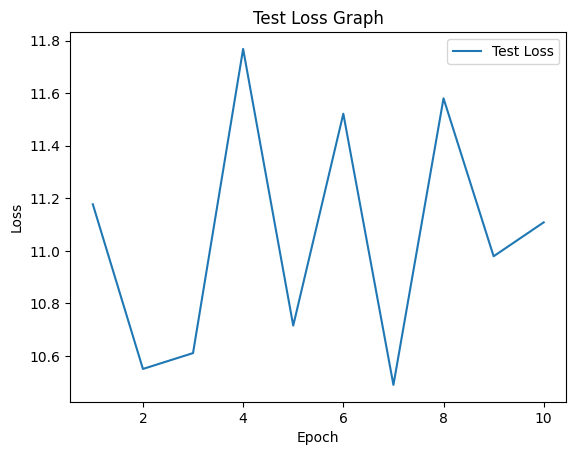

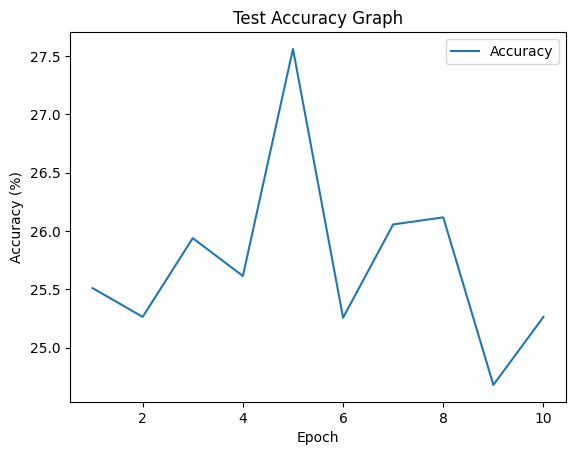

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def test_yolo_v8(epoch):
    weights_path = glob.glob(ROOT+"weights/*.pth")
    if len(weights_path) == 0:
        print("No weights file present in weights/")
        return

    weights_path = weights_path[0]  # takes the file to load
    print("Loading Weights:", weights_path)

    transform_test = A.Compose(
        [A.Resize(height=DIM, width=DIM),
         A.CLAHE(p=1.0),
         A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
         ToTensorV2()],
        bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
    )

    yolo_v8_model.load_state_dict(torch.load(weights_path))
    yolo_v8_model.eval()

    test_data = BrainDataset(ANCHORS, transform=transform_test, mode="test", root=ROOT)
    test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, pin_memory=True)
    test_losses = []
    correct_predictions = 0
    total_predictions = 0

    with tqdm(test_dataloader, unit=" Test batch") as tepoch:
        for input_images, labels, image_paths, label_paths in tepoch:
            batch_size = input_images.shape[0]
            y0, y1, y2 = (
                labels[0],
                labels[1],
                labels[2],
            )
            with torch.no_grad():
                out = yolo_v8_model(input_images)
                loss = loss_fn(out[0], y0, scaled_anchors[0]) + loss_fn(out[1], y1, scaled_anchors[1]) + loss_fn(
                    out[2], y2, scaled_anchors[2])
                test_losses.append(loss.item())
                bboxes = [[] for _ in range(batch_size)]

                for i in range(3):
                    S = out[i].shape[2]
                    anchor = torch.tensor([*ANCHORS[i]]) * S
                    boxes_scale_i = cells_to_bboxes(
                        out[i], anchor, S=S, is_preds=True
                    )
                    for idx, (box) in enumerate(boxes_scale_i):
                        bboxes[idx] += box

                all_pred_boxes = []  # specified as [class_prediction, prob_score, cx, cy, w, h]

                for idx in range(batch_size):
                    nms_boxes = non_max_suppression(
                        bboxes[idx],
                        iou_threshold=NMS_IOU_THRESH,
                        threshold=CONF_THRESHOLD,
                        box_format="midpoint",
                    )

                    for nms_box in nms_boxes:
                        all_pred_boxes.append(nms_box)

                    for image_idx in range(len(image_paths)):
                        image_path = image_paths[image_idx]
                        label_path = label_paths[image_idx]
                        image = cv2.imread(image_path) # its a square dimensional image 256x256
                        image = cv2.resize(image, (DIM, DIM))
                        gt_image = image.copy()
                        pred_image = image
                        label_data = np.loadtxt(label_path, delimiter = " ", ndmin=2).tolist()
                        for iddx in range(len(label_data)):
                            label_data[iddx].insert(1,1)
                        # for gt in all_true_boxes:
                        #     gt_image = plot(gt_image, gt, "green")
                        for gt in label_data:
                            gt_image = plot(gt_image, gt, "green")
                        for pred in all_pred_boxes:
                            pred_image = plot(image, pred, "red")
                        save_image(gt_image, pred_image, image_path)

                        image_path = image_paths[image_idx]
                        label_path = label_paths[image_idx]
                        label_data = np.loadtxt(label_path, delimiter=" ", ndmin=2).tolist()
                        for iddx in range(len(label_data)):
                            label_data[iddx].insert(1, 1)
                        for pred in all_pred_boxes:
                            pred_class = int(pred[0])
                            pred_cx, pred_cy, pred_w, pred_h = pred[2], pred[3], pred[4], pred[5]
                            for gt in label_data:
                                gt_class = int(gt[0])
                                gt_cx, gt_cy, gt_w, gt_h = gt[2], gt[3], gt[4], gt[5]
                                if pred_class == gt_class:
                                    total_predictions += 1
                                    if (abs(pred_cx - gt_cx) <= 0.5 * (pred_w + gt_w)) and (
                                            abs(pred_cy - gt_cy) <= 0.5 * (pred_h + gt_h)):
                                        correct_predictions += 1
                                        break

    accuracy = correct_predictions / total_predictions * 100 if total_predictions != 0 else 0
    print(f'Epoch {epoch} - Accuracy: {accuracy:.2f}%')
    print(f'Epoch {epoch} - Test Loss: {np.mean(test_losses)}')
    return np.mean(test_losses), accuracy

test_losses = []
accuracies = []
num_epochs = 10  # Change this to the number of epochs you want to run
for epoch in range(1, num_epochs + 1):
    test_loss, accuracy = test_yolo_v8(epoch)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# Plotting test loss over epochs
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Graph')
plt.legend()
plt.show()

# Plotting accuracy over epochs
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Graph')
plt.legend()
plt.show()

